# Comparation Inference Diferent Runtimes

# Requirements
- python 3.11
- Debian 10 in WSL2
- openvino_req.txt

# RestNet50
Deep Residual Learning for Image Recognition --> https://arxiv.org/abs/1512.03385
Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. We explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions.

### PyTorch CPU & CUDA
In the provided code, we perform inference using the native PyTorch framework on both CPU and GPU (CUDA) configurations. This is a baseline to compare the performance improvements gained from other optimization techniques.

- https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html
- https://pytorch.org/TensorRT/user_guide/torch_compile.html
- https://pytorch.org/docs/stable/generated/torch.jit.trace.html

### TensorRT FP32 & FP16

- https://developer.nvidia.com/blog/accelerating-inference-up-to-6x-faster-in-pytorch-with-torch-tensorrt/
- https://developer.nvidia.com/tensorrt-getting-started

TensorRT offers significant performance improvements by optimizing the neural network model. This code uses TensorRT's capabilities to run benchmarks in FP32 (single precision) and FP16 (half precision) modes.

### ONNX
The code includes an exporter that converts the PyTorch ResNet-50 model to ONNX format, allowing it to be inferred using ONNX Runtime. This provides a flexible, cross-platform solution for deploying the model.

### OpenVINO
OpenVINO is a toolkit from Intel that optimizes deep learning model inference for Intel CPUs, GPUs, and other hardware. We convert the ONNX model to OpenVINO's format in the code and then run benchmarks using the OpenVINO runtime.


### NVIDIA TensorRT Model Optimizer
A Library to Quantize and Compress Deep Learning Models for Optimized Inference on GPUs.

pip install "nvidia-modelopt[all]~=0.15.0" --extra-index-url https://pypi.nvidia.com


## References
- **PyTorch**: [Official Documentation](https://pytorch.org/docs/stable/index.html)
- **Torch-TensorRT**: is a compiler for PyTorch/TorchScript, targeting NVIDIA GPUs via NVIDIA’s TensorRT Deep Learning Optimizer and Runtime. [Torch-TensorRT Documentation](https://pytorch.org/TensorRT/)
- **torch.onnx**: PyTorch's built-in ONNX exporter. [Documentation](https://pytorch.org/docs/stable/onnx.html)
- **OpenVINO**: Intel's toolkit for computer vision applications includes a model optimizer to convert trained models into a format suitable for optimal execution on end-point target devices. [Official Documentation](https://docs.openvinotoolkit.org/latest/index.html)
- **OpenVINO - Converting ONNX to OV**: [Convert Model From ONNX](https://docs.openvino.ai/2023.1/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_ONNX.html)


### Acknowledge
Thanks to Dima Birenbaum for his excellent job , which is the base of this Notebook

In [1]:
import torch
# import torch_tensorrt
import logging
from src.inference_base import InferenceBase
import torch_tensorrt
from common.utils import parse_arguments, plot_benchmark_results
from src.image_processor import ImageProcessor
from src.model import ModelLoader
import warnings
# Check for CUDA and TensorRT availability
CUDA_AVAILABLE = torch.cuda.is_available()
if CUDA_AVAILABLE:
    try:
        import torch_tensorrt as trt
    except ImportError:
        logging.warning("torch-tensorrt is not installed. Running on CPU mode only.")
        CUDA_AVAILABLE = False

/home/olonok/.local/lib/python3.11/site-packages/modelopt/torch/quantization/tensor_quant.py:92: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  scaled_e4m3_abstract = torch.library.impl_abstract("trt::quantize_fp8")(


In [18]:
image_path = "inference/cat3.jpg"
onnx_path = "models/model.onnx"

In [19]:
from PIL import Image

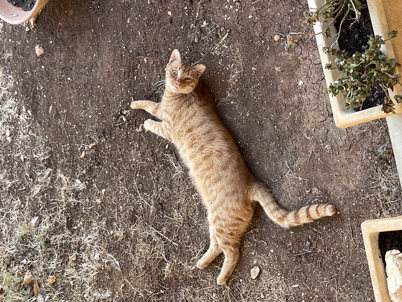

In [23]:
img = Image.open(image_path)
img.resize(size=(402,302))

In [32]:
# Model and Image Initialization
benchmark_results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loader = ModelLoader(device=device)
img_processor = ImageProcessor(img_path=image_path, device=device)
img_batch = img_processor.process_image()

print(device)

  img_batch = img_processor.process_image()



cuda


# ONNX CPU

In [4]:
from src.onnx_inference import ONNXInference
onnx_inference = ONNXInference(model_loader, onnx_path)

benchmark_results["ONNX (CPU)"] = onnx_inference.benchmark(img_batch)
onnx_probs = onnx_inference.predict(img_batch)

INFO:root:Starting warmup for ONNXInference inference...
INFO:root:Starting benchmark for ONNXInference inference...
INFO:root:Average inference time for 100 runs: 84.8847 ms
INFO:root:Throughput for ONNXInference: 4.42 samples/sec
INFO:root:Running prediction for ONNXInference model
INFO:root:#1: 11% Egyptian cat
INFO:root:#2: 9% tiger cat
INFO:root:#3: 7% tabby
INFO:root:#4: 1% carton
INFO:root:#5: 1% lynx


In [24]:
benchmark_results

{'ONNX (CPU)': (84.88472878932953, 4.417555954259864),
 'OpenVINO (CPU)': (76.92548304796219, 4.874723117432146),
 'PyTorch (CPU)': (197.91452288627625, 1.8947373166706292),
 'PyTorch (CUDA)': (16.95993274450302, 22.10854127464055),
 'TRT_torch.float32': (5.743902325630188, 65.25788584545883)}

# OpenVino Inference

In [5]:
from src.ov_inference import OVInference
ov_inference = OVInference(model_loader, onnx_path)

benchmark_results["OpenVINO (CPU)"] = ov_inference.benchmark(img_batch)
ov_probs =ov_inference.predict(img_batch)

INFO:root:Starting warmup for OVInference inference...
INFO:root:Starting benchmark for OVInference inference...
INFO:root:Average inference time for 100 runs: 76.9255 ms
INFO:root:Throughput for OVInference: 4.87 samples/sec
INFO:root:Running prediction for OVInference model
INFO:root:#1: 11% Egyptian cat
INFO:root:#2: 9% tiger cat
INFO:root:#3: 7% tabby
INFO:root:#4: 1% carton
INFO:root:#5: 1% lynx


# PyTorch CPU

In [6]:
from src.pytorch_inference import PyTorchInference
pytorch_cpu_inference = PyTorchInference(
            model_loader, device="cpu"
        )

benchmark_results["PyTorch (CPU)"] = pytorch_cpu_inference.benchmark(img_batch)
pytorch_cpu_probs = pytorch_cpu_inference.predict(img_batch)

INFO:root:Starting warmup for PyTorchInference inference...
INFO:root:Starting benchmark for PyTorchInference inference...
INFO:root:Average inference time for 100 runs: 197.9145 ms
INFO:root:Throughput for PyTorchInference: 1.89 samples/sec
INFO:root:Running prediction for PyTorchInference model
INFO:root:#1: 11% Egyptian cat
INFO:root:#2: 9% tiger cat
INFO:root:#3: 7% tabby
INFO:root:#4: 1% carton
INFO:root:#5: 1% lynx


# Pytorch GPU

In [7]:
pytorch_cuda_inference = PyTorchInference(
                model_loader, device=device
            )

benchmark_results["PyTorch (CUDA)"] = pytorch_cuda_inference.benchmark(
    img_batch
)
pytorch_gpu_probs =pytorch_cuda_inference.predict(img_batch)

INFO:root:Starting warmup for PyTorchInference inference...
INFO:root:Starting benchmark for PyTorchInference inference...
INFO:root:Average inference time for 100 runs: 16.9599 ms
INFO:root:Throughput for PyTorchInference: 22.11 samples/sec
INFO:root:Running prediction for PyTorchInference model
INFO:root:#1: 11% Egyptian cat
INFO:root:#2: 9% tiger cat
INFO:root:#3: 7% tabby
INFO:root:#4: 1% carton
INFO:root:#5: 1% lynx


# TensorRT GPU

In [26]:
from src.tensorrt_inference import TensorRTInference
precisions = [torch.float16, torch.float32]
for precision in precisions:
    tensorrt_inference = TensorRTInference(
        model_loader,
        device=device,
        precision=precision,

    )

    benchmark_results[f"TRT_{precision}"] = tensorrt_inference.benchmark(
            img_batch
        )
tensorrt_gpu_probs = tensorrt_inference.predict(img_batch)

The compiler is going to use the user setting Half
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x.1
- Disable partial compilation by setting require_full_compilation to True
The compiler is going to use the user setting Half
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x.1
- Disable partial compilation by setting require_full_compilation to True
INFO:root:Starting warmup for TensorRTInference inference...
INFO:root:Starting benchmark for TensorRTInference inference...
INFO:root:Average inference time for 100 runs: 3.5366 ms
INFO:root:Throughput for TensorRTInference: 105.99 samples/sec
INFO:root:Starting warm

In [27]:
benchmark_results

{'ONNX (CPU)': (84.88472878932953, 4.417555954259864),
 'OpenVINO (CPU)': (76.92548304796219, 4.874723117432146),
 'PyTorch (CPU)': (197.91452288627625, 1.8947373166706292),
 'PyTorch (CUDA)': (16.95993274450302, 22.10854127464055),
 'TRT_torch.float32': (5.532585084438324, 67.75952529335966),
 'TRT_torch.float16': (3.5365888476371765, 105.98647965926409)}

# Plot Output

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple


def plot_benchmark_results(results: Dict[str, Tuple[float, float]]):
    """
    Plot the benchmark results using Seaborn.

    :param results: Dictionary where the key is the model type and the value is a tuple (average inference time, throughput).
    """
    plot_path = "./inference/plot.png"

    # Extract data from the results
    models = list(results.keys())
    times = [value[0] for value in results.values()]
    throughputs = [value[1] for value in results.values()]

    # Create DataFrames for plotting
    time_data = pd.DataFrame({"Model": models, "Time": times})
    throughput_data = pd.DataFrame({"Model": models, "Throughput": throughputs})

    # Sort the DataFrames
    time_data = time_data.sort_values("Time", ascending=True)
    throughput_data = throughput_data.sort_values("Throughput", ascending=False)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Plot inference times
    sns.barplot(
        x=time_data["Time"],
        y=time_data["Model"],
        hue=time_data["Model"],
        palette="rocket",
        ax=ax1,
        legend=False,
    )
    ax1.set_xlabel("Average Inference Time (ms)")
    ax1.set_ylabel("Model Type")
    ax1.set_title("ResNet50 - Inference Benchmark Results")
    for index, value in enumerate(time_data["Time"]):
        ax1.text(value, index, f"{value:.2f} ms", color="black", ha="left", va="center")

    # Plot throughputs
    sns.barplot(
        x=throughput_data["Throughput"],
        y=throughput_data["Model"],
        hue=throughput_data["Model"],
        #palette="viridis",
        ax=ax2,
        legend=False,
    )
    ax2.set_xlabel("Throughput (samples/sec)")
    ax2.set_ylabel("")
    ax2.set_title("ResNet50 - Throughput Benchmark Results")
    for index, value in enumerate(throughput_data["Throughput"]):
        ax2.text(value, index, f"{value:.2f}", color="black", ha="left", va="center")

    # Save the plot to a file
    plt.tight_layout()
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

    print(f"Plot saved to {plot_path}")

### Plot details:
1. **Average Inference Time**: This plot showcases the average time taken for inference across different model types and optimization techniques. The y-axis represents the model type (e.g., PyTorch CPU, TensorRT FP16, etc.), and the x-axis represents the average inference time in milliseconds. The shorter the bar, the faster the inference time.

2. **Throughput**: This plot compares the throughput achieved by different model types. Throughput is measured in terms of the number of images processed per second. The y-axis represents the model type, and the x-axis represents the throughput. A higher bar indicates better throughput, meaning the model can process more images in a given time frame.

These plots offer a comprehensive view of the performance improvements achieved by various inference optimization techniques, especially when leveraging TensorRT with different precision types like FP16 and FP32.


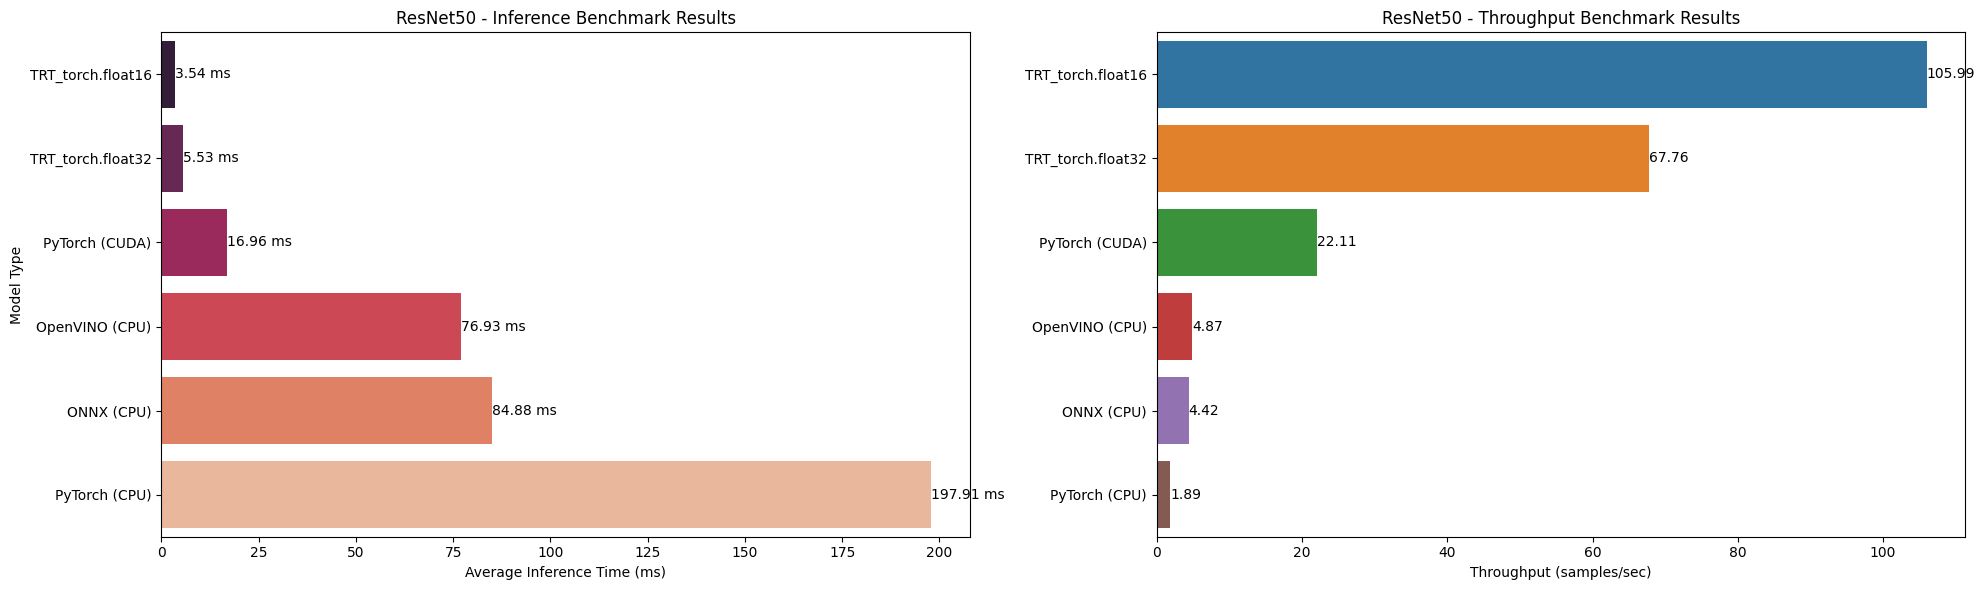

Plot saved to ./inference/plot.png


In [29]:
plot_benchmark_results(benchmark_results)